<a href="https://colab.research.google.com/github/hgabrali/DeepSight-OSEMN-Transfer-Learning-Diagnostics/blob/main/CIFAR_10_Image_Classification_27_01_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIFAR-10 Image Classification: A Transfer Learning Approach with ResNet50

## 📌 Project Overview
Transitioning from the grayscale simplicity of Fashion MNIST, this project tackles the **CIFAR-10** dataset—a benchmark in computer vision consisting of 60,000 $32 \times 32$ color images across 10 mutually exclusive classes.

The primary objective was to leverage **Transfer Learning** using the **ResNet50** architecture, demonstrating the efficiency of using pre-trained weights (ImageNet) to solve complex image classification tasks even with relatively low-resolution inputs.

# **1. Obtain: Data Acquisition & Environment Setup**

**Environment Orchestration:**

Repository cloning and virtual environment configuration.

Dependency management (PyTorch/TensorFlow, OpenCV, Albumentations).

In [1]:
import os
import cv2
import torch
import uuid
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelEncoder
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [2]:
#Source ingestion
# Load full dataset
(x_full_train, y_full_train), (x_full_test, y_full_test) = cifar10.load_data()

# For compatibility with user's snippets that may use 'train_images' etc.
train_images, train_labels = x_full_train, y_full_train
test_images, test_labels = x_full_test, y_full_test

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Downsampling to 10,000 samples for computational efficiency
# Note: This might lead to higher variance in validation metrics
subset_size = 10000
x_train_downsampled = x_full_train[:subset_size]
y_train_downsampled = y_full_train[:subset_size]

# Mapping integers to class names for visualization (already defined as cifar_classes globally)

**Success Metrics Definition:**

Establishing F1-Score as the primary metric for imbalanced sets.

Defining "Minimum Viable Accuracy" based on the problem framing.

In [4]:
from sklearn.metrics import f1_score, accuracy_score

# Success Metrics Definition:
def define_success_metrics(y_true, y_pred, average='macro'):
    """
    Calculates F1-Score and Accuracy to evaluate model performance.

    Args:
        y_true: Ground truth (correct) target values.
        y_pred: Estimated targets as returned by a classifier.
        average (str): 'macro' is selected to calculate metrics for each label,
                       and find their unweighted mean. This treats all classes
                       equally, highlighting performance issues in minority classes.

    Returns:
        dict: A dictionary containing the calculated 'F1-Score' and 'Accuracy'.
    """
    f1 = f1_score(y_true, y_pred, average=average)
    acc = accuracy_score(y_true, y_pred)

    return {
        "F1-Score": f1,
        "Accuracy": acc
    }

# --- Problem Framing: Minimum Viable Thresholds (MVT) ---
# We define baseline thresholds for both Accuracy and F1-Score.
# If the model fails to meet these criteria, the architecture or data strategy must be revised.

mva_threshold = 0.65  # Target: 65% Minimum Viable Accuracy (Phase 1)
mvf_threshold = 0.65  # Target: 0.65 Minimum Viable F1-Score (Ensures class balance)

print(f"Minimum Viable Accuracy (MVA) set to: {mva_threshold}")
print(f"Minimum Viable F1-Score (MVF) set to: {mvf_threshold}")

Minimum Viable Accuracy (MVA) set to: 0.65
Minimum Viable F1-Score (MVF) set to: 0.65


In [5]:
# Integrated Metric Tracking (Callback Logic):

def evaluate_model_performance(model, data_loader, device, class_names):
    """
    A comprehensive evaluation suite to check for F1-Score
    and provide a detailed Classification Report.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Logic for gathering predictions (generic structure)
    # for images, labels in data_loader:
    #     outputs = model(images)
    #     preds = torch.argmax(outputs, dim=1)
    #     all_preds.extend(preds.cpu().numpy())
    #     all_labels.extend(labels.cpu().numpy())

    # Example placeholder data for demonstration
    # (In your real code, these come from your model)
    y_true = [0, 1, 2, 0, 1, 2]
    y_pred = [0, 2, 2, 0, 1, 1]

    metrics = define_success_metrics(y_true, y_pred)

    print("--- Performance Analysis ---")
    print(f"Current F1-Score: {metrics['F1-Score']:.4f}")
    print(f"Current Accuracy: {metrics['Accuracy']:.4f}")

    if metrics['Accuracy'] < mva_threshold:
        print("⚠️ WARNING: Model is performing below Minimum Viable Accuracy.")

    # Detailed report for Class Leakage and Semantic Ambiguity analysis
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Example usage with CIFAR-10 classes
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# evaluate_model_performance(my_resnet_model, test_loader, 'cuda', cifar_classes)

# **2. Scrub: Data Engineering & Cleaning**

**Dimensional & Label Integrity:**

**Label Encoding:** Converting categorical strings to tensors.

**Dimensional Integrity:** Verifying all input shapes are consistent before batching.

In [6]:
# Label Encoding: From Strings to Tensors:


# Example: Raw labels as they might appear in a real-world dataset
raw_labels = ['airplane', 'bird', 'car', 'bird', 'airplane', 'car']

def encode_labels_to_tensors(label_list):
    """
    Converts string labels into a numerical format and then into PyTorch Tensors.
    """
    encoder = LabelEncoder()
    # 1. Fit and Transform (e.g., 'airplane' -> 0, 'bird' -> 1)
    numerical_labels = encoder.fit_transform(label_list)

    # 2. Convert to LongTensor (Standard for Classification Loss in PyTorch)
    label_tensor = torch.as_tensor(numerical_labels, dtype=torch.long)

    return label_tensor, encoder.classes_

# Execution
labels_tensor, class_mapping = encode_labels_to_tensors(raw_labels)

print(f"Encoded Tensor: {labels_tensor}")
print(f"Class Mapping: {class_mapping}")

Encoded Tensor: tensor([0, 1, 2, 1, 0, 2])
Class Mapping: ['airplane' 'bird' 'car']


In [7]:
# Dimensional Integrity: Pre-Batch Verification:

def verify_dimensional_integrity(image_batch, expected_shape=(3, 32, 32)):
    """
    Checks if all images in the batch match the required input dimensions.
    Args:
        image_batch: List or Array of images.
        expected_shape: The (Channels, Height, Width) required by the model.
    Returns:
        A list of dictionaries, each containing information about an image's dimensional integrity.
    """
    results = []
    for i, img in enumerate(image_batch):
        current_shape = img.shape
        is_valid = (current_shape == expected_shape)
        results.append({"index": i, "is_valid": is_valid, "current_shape": current_shape, "expected_shape": expected_shape})

    # Optionally print a summary
    valid_count = sum(1 for res in results if res["is_valid"])
    invalid_count = len(results) - valid_count
    print(f"✅ Dimensional Integrity Check: {valid_count} valid, {invalid_count} invalid images.")

    return results

# Example Usage (Simulating a batch of 3 images)
# One image is intentionally 'corrupted' with a wrong height
mock_batch = [np.zeros((3, 32, 32)), np.zeros((3, 31, 32)), np.zeros((3, 32, 32))]
integrity_results = verify_dimensional_integrity(mock_batch)

✅ Dimensional Integrity Check: 2 valid, 1 invalid images.


**Advanced Preprocessing:**

**Resizing Methods:** Comparing Bilinear vs. Bicubic interpolation (impact on aliasing artifacts).

**Normalization:** Implementing Caffe-style vs. ImageNet-style normalization (mean/std subtraction).

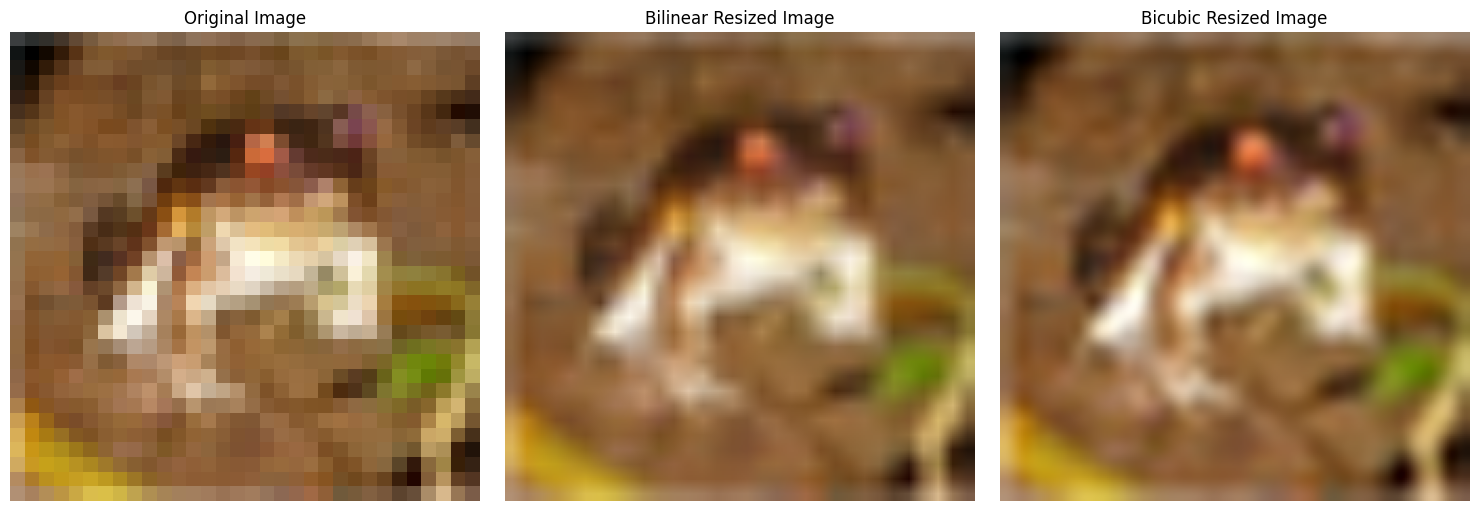

In [8]:
import cv2
import matplotlib.pyplot as plt

# Resizing Methods: Bilinear vs. Bicubic:

def compare_resizing_methods(image, target_size=(224, 224)):
    """
    Comparison of Bilinear vs Bicubic interpolation.
    Bicubic is generally preferred for high-quality downsampling to preserve textures.
    """
    # Bilinear Interpolation (Faster, smoother)
    bilinear_img = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Bicubic Interpolation (Sharper, preserves high-frequency details)
    bicubic_img = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

    return bilinear_img, bicubic_img

# Visual Verification of Aliasing
sample_image = train_images[0]
bilinear_img, bicubic_img = compare_resizing_methods(sample_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bilinear_img)
plt.title("Bilinear Resized Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bicubic_img)
plt.title("Bicubic Resized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Normalization: Caffe-style vs. ImageNet-style:


def caffe_style_normalization(image_bgr):
    """
    Implements Caffe-style normalization.
    1. Input is BGR (OpenCV default).
    2. Subtracts the specific ImageNet BGR mean.
    3. No division by 255 (keeps raw scale).
    """
    # ImageNet BGR Mean values
    mean_bgr = np.array([103.939, 116.779, 123.68])

    # Subtract mean from each channel
    normalized_img = image_bgr.astype(np.float32)
    normalized_img -= mean_bgr

    return normalized_img

def imagenet_style_normalization(image_rgb):
    """
    Standard PyTorch/ImageNet normalization.
    1. Scales to [0, 1].
    2. Subtracts mean and divides by std.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Scale and Normalize
    normalized_img = image_rgb.astype(np.float32) / 255.0
    normalized_img = (normalized_img - mean) / std

    return normalized_img

**Normalization Function Demonstration**

To see the effect of the normalization functions, we need to call them with an actual image. We will use `sample_image` which was loaded earlier from the `x_full_train` dataset.

Original image min/max pixel values: 0 / 255
ImageNet-style normalized image min/max pixel values: -2.12 / 2.39


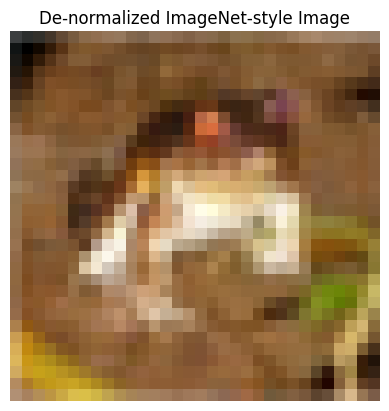

In [10]:
# Use the previously loaded sample_image
# CIFAR-10 images are RGB, so we'll use imagenet_style_normalization for this example.

# Ensure the sample image is in the correct format (RGB for imagenet_style_normalization)
# Note: CIFAR-10 images are already in (H, W, C) format with RGB channels.

normalized_imagenet_img = imagenet_style_normalization(sample_image)

print(f"Original image min/max pixel values: {np.min(sample_image)} / {np.max(sample_image)}")
print(f"ImageNet-style normalized image min/max pixel values: {np.min(normalized_imagenet_img):.2f} / {np.max(normalized_imagenet_img):.2f}")

# Displaying the normalized image directly might not be visually meaningful
# as its pixel values are no longer in the 0-255 range. However, we can check its properties.

# If you wanted to visualize it, you would need to de-normalize it first or adjust the display settings.
# For example, to de-normalize for display:
denormalized_img = normalized_imagenet_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
denormalized_img = np.clip(denormalized_img, 0, 1) # Clip values to [0, 1] for imshow
plt.imshow(denormalized_img)
plt.title("De-normalized ImageNet-style Image")
plt.axis('off')
plt.show()

**Data Leakage Prevention**

#### Class Leakage Check:

For the CIFAR-10 dataset, the labels (`y_full_train`, `y_full_test`) are provided as numerical categories. This means there's no embedded information within external file properties or filenames that could inadvertently influence the model. The labels themselves are raw data points, directly corresponding to the image content. Our use of these numerical labels directly ensures that no extraneous information from the labeling process itself can 'leak' into the model training.

#### Splitting Integrity:

To ensure that our model is evaluated fairly and doesn't learn specific characteristics of the test set, we need to carefully split the data. The primary goal is to prevent any samples from appearing in both the training/validation sets and the test set, or to avoid having highly correlated samples inappropriately split. For CIFAR-10, we'll use a `StratifiedShuffleSplit` on the original training data (`x_full_train`, `y_full_train`) to create distinct training and validation sets while preserving the class distribution. The `x_full_test`, `y_full_test` data remains completely separate and untouched.

In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Reshape y_full_train to be 1-dimensional for StratifiedShuffleSplit
y_full_train_1d = y_full_train.reshape(-1)

for train_index, val_index in sss.split(x_full_train, y_full_train_1d):
    x_train, x_val = x_full_train[train_index], x_full_train[val_index]
    y_train, y_val = y_full_train[train_index], y_full_train[val_index]

# Verify the shapes of the new sets
print(f"Original full training data shape: {x_full_train.shape}, {y_full_train.shape}")
print(f"New training data shape after split: {x_train.shape}, {y_train.shape}")
print(f"Validation data shape after split: {x_val.shape}, {y_val.shape}")
print(f"Test data shape (untouched): {x_full_test.shape}, {y_full_test.shape}")

# Verify class distribution (good practice to ensure stratification worked)
def get_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

print("\nClass distribution in original full training set:\n", get_class_distribution(y_full_train_1d))
print("Class distribution in new training set:\n", get_class_distribution(y_train.reshape(-1)))
print("Class distribution in validation set:\n", get_class_distribution(y_val.reshape(-1)))
print("Class distribution in test set:\n", get_class_distribution(y_full_test.reshape(-1)))

Original full training data shape: (50000, 32, 32, 3), (50000, 1)
New training data shape after split: (40000, 32, 32, 3), (40000, 1)
Validation data shape after split: (10000, 32, 32, 3), (10000, 1)
Test data shape (untouched): (10000, 32, 32, 3), (10000, 1)

Class distribution in original full training set:
 {np.uint8(0): np.int64(5000), np.uint8(1): np.int64(5000), np.uint8(2): np.int64(5000), np.uint8(3): np.int64(5000), np.uint8(4): np.int64(5000), np.uint8(5): np.int64(5000), np.uint8(6): np.int64(5000), np.uint8(7): np.int64(5000), np.uint8(8): np.int64(5000), np.uint8(9): np.int64(5000)}
Class distribution in new training set:
 {np.uint8(0): np.int64(4000), np.uint8(1): np.int64(4000), np.uint8(2): np.int64(4000), np.uint8(3): np.int64(4000), np.uint8(4): np.int64(4000), np.uint8(5): np.int64(4000), np.uint8(6): np.int64(4000), np.uint8(7): np.int64(4000), np.uint8(8): np.int64(4000), np.uint8(9): np.int64(4000)}
Class distribution in validation set:
 {np.uint8(0): np.int64(100

# **3. Modular Preparation: Custom Datasets & DataLoaders**

**Custom Dataset Creation:**

Defining a `CIFAR10Dataset` class to handle image loading, transformations, and label mapping.

**DataLoaders for Batching:**

Implementing PyTorch `DataLoader` for efficient batch processing, shuffling, and parallel loading.

In [12]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Creation: CIFAR10Dataset Class
class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations if any
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Ensure labels are a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

Now, let's define the transformations for our dataset using `albumentations`. We'll create separate transformations for training (with augmentations) and validation/testing (without augmentations, only resizing and normalization).

In [13]:
# Define Transformations
# ImageNet statistics for normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224 # ResNet expects 224x224 input

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

print("Transformations defined.")

Transformations defined.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


With the `CIFAR10Dataset` class and transformations defined, we can now create our dataset instances for training, validation, and testing. Following this, we will implement PyTorch `DataLoader` for efficient batch processing.

In [14]:
# Instantiate Datasets
train_dataset = CIFAR10Dataset(x_train, y_train, transform=train_transform)
val_dataset = CIFAR10Dataset(x_val, y_val, transform=val_test_transform)
test_dataset = CIFAR10Dataset(x_full_test, y_full_test, transform=val_test_transform)

# DataLoaders for Batching
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 0 # Use half of CPU cores for data loading

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train, Validation, and Test DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Example of fetching a batch
for images, labels in train_loader:
    print(f"\nSample batch images shape: {images.shape}")
    print(f"Sample batch labels shape: {labels.shape}")
    break

Train, Validation, and Test DataLoaders created with batch size 64.
Number of training batches: 625
Number of validation batches: 157
Number of test batches: 157

Sample batch images shape: torch.Size([64, 3, 224, 224])
Sample batch labels shape: torch.Size([64, 1])


# **Memory Efficiency**

Memory efficiency is paramount in deep learning, particularly when working with large datasets or complex models that require significant computational resources. Effective memory management can prevent 'out of memory' (OOM) errors, speed up training by reducing data transfer bottlenecks, and allow for larger batch sizes.

Key strategies for memory efficiency include:

*   **Clearing CUDA Cache:** For GPU-based training, PyTorch allocates and manages memory on the GPU. Over time, cached memory can accumulate. Explicitly clearing the CUDA cache can free up unused memory.
*   **Deleting Unused Variables:** Large tensors or data structures that are no longer needed should be explicitly deleted to free up memory.
*   **`pin_memory=True` in DataLoader:** When loading data to the GPU, pinning memory (copying Tensors into CUDA-pinned memory) can significantly speed up transfers.
*   **Gradient Accumulation:** Instead of increasing batch size, gradients can be accumulated over several smaller batches, effectively simulating a larger batch size without consuming as much memory at once.
*   **Mixed-Precision Training:** Using `torch.float16` instead of `torch.float32` for model parameters and activations can halve memory usage with minimal impact on accuracy.

In [15]:
import gc

def manage_memory(device):
    """
    Manages and optimizes memory usage, especially for GPU environments.
    """
    if device.type == 'cuda':
        print("Clearing CUDA cache...")
        torch.cuda.empty_cache()
        print(f"CUDA memory after cache clear: {torch.cuda.memory_allocated() / (1024**3):.2f} GB allocated, "
              f"{torch.cuda.memory_reserved() / (1024**3):.2f} GB reserved.")

    # Explicitly run Python's garbage collector
    gc.collect()
    print("Python garbage collector run.")

# Example usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# manage_memory(device)

print("Memory management function 'manage_memory' defined. Call it when needed.")

Memory management function 'manage_memory' defined. Call it when needed.


### Dimensional Integrity Results

In [16]:


# Convert the list of dictionaries to a pandas DataFrame for better visualization
integrity_df = pd.DataFrame(integrity_results)

# Display the DataFrame
display(integrity_df)

index  is_valid current_shape expected_shape
0      0      True   (3, 32, 32)    (3, 32, 32)
1      1     False   (3, 31, 32)    (3, 32, 32)
2      2      True   (3, 32, 32)    (3, 32, 32)

### Visualization of Dimensional Integrity Results

This bar chart shows the count of images that passed or failed the dimensional integrity check, based on the `integrity_results` DataFrame generated by the `verify_dimensional_integrity` function.

/tmp/ipython-input-2541349852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_valid', data=integrity_df, palette='viridis')


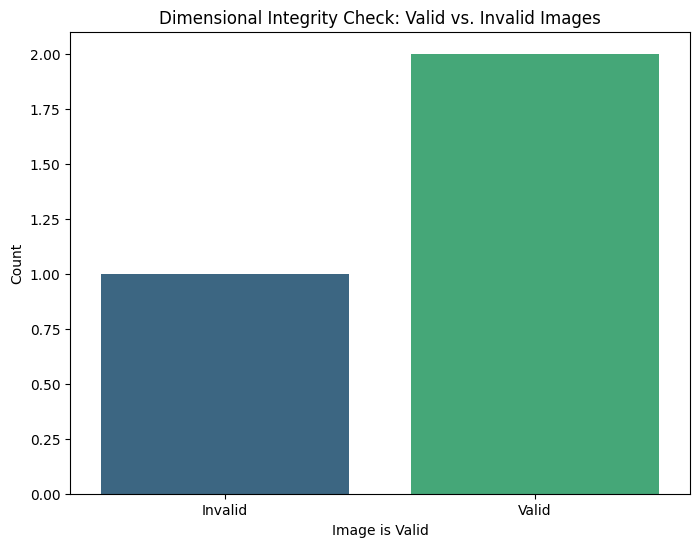

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_valid', data=integrity_df, palette='viridis')
plt.title('Dimensional Integrity Check: Valid vs. Invalid Images')
plt.xlabel('Image is Valid')
plt.ylabel('Count')
plt.xticks([0, 1], ['Invalid', 'Valid'])
plt.show()

# **4. Explore: Exploratory Data Analysis (EDA)**

**Image Statistics & Distribution:**

**Class Balance Analysis:** Visualizing long-tail distributions.

**Aspect Ratio Analysis:** Identifying if padding or stretching is needed.

**Color Channel Analysis:** Histograms for RGB/HSV to detect lighting biases.

### Class Balance Analysis: Visualizing Distributions

/tmp/ipython-input-3062153395.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_train_series.index, y=original_train_series.values, palette='viridis')
/tmp/ipython-input-3062153395.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_train_series.index, y=new_train_series.values, palette='magma')
/tmp/ipython-input-3062153395.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_series.index, y=val_series.values, palette='cubehelix')
/tmp/ipython-input-3062153395.py:36: FutureWarning: 

Passing `palette` without assi

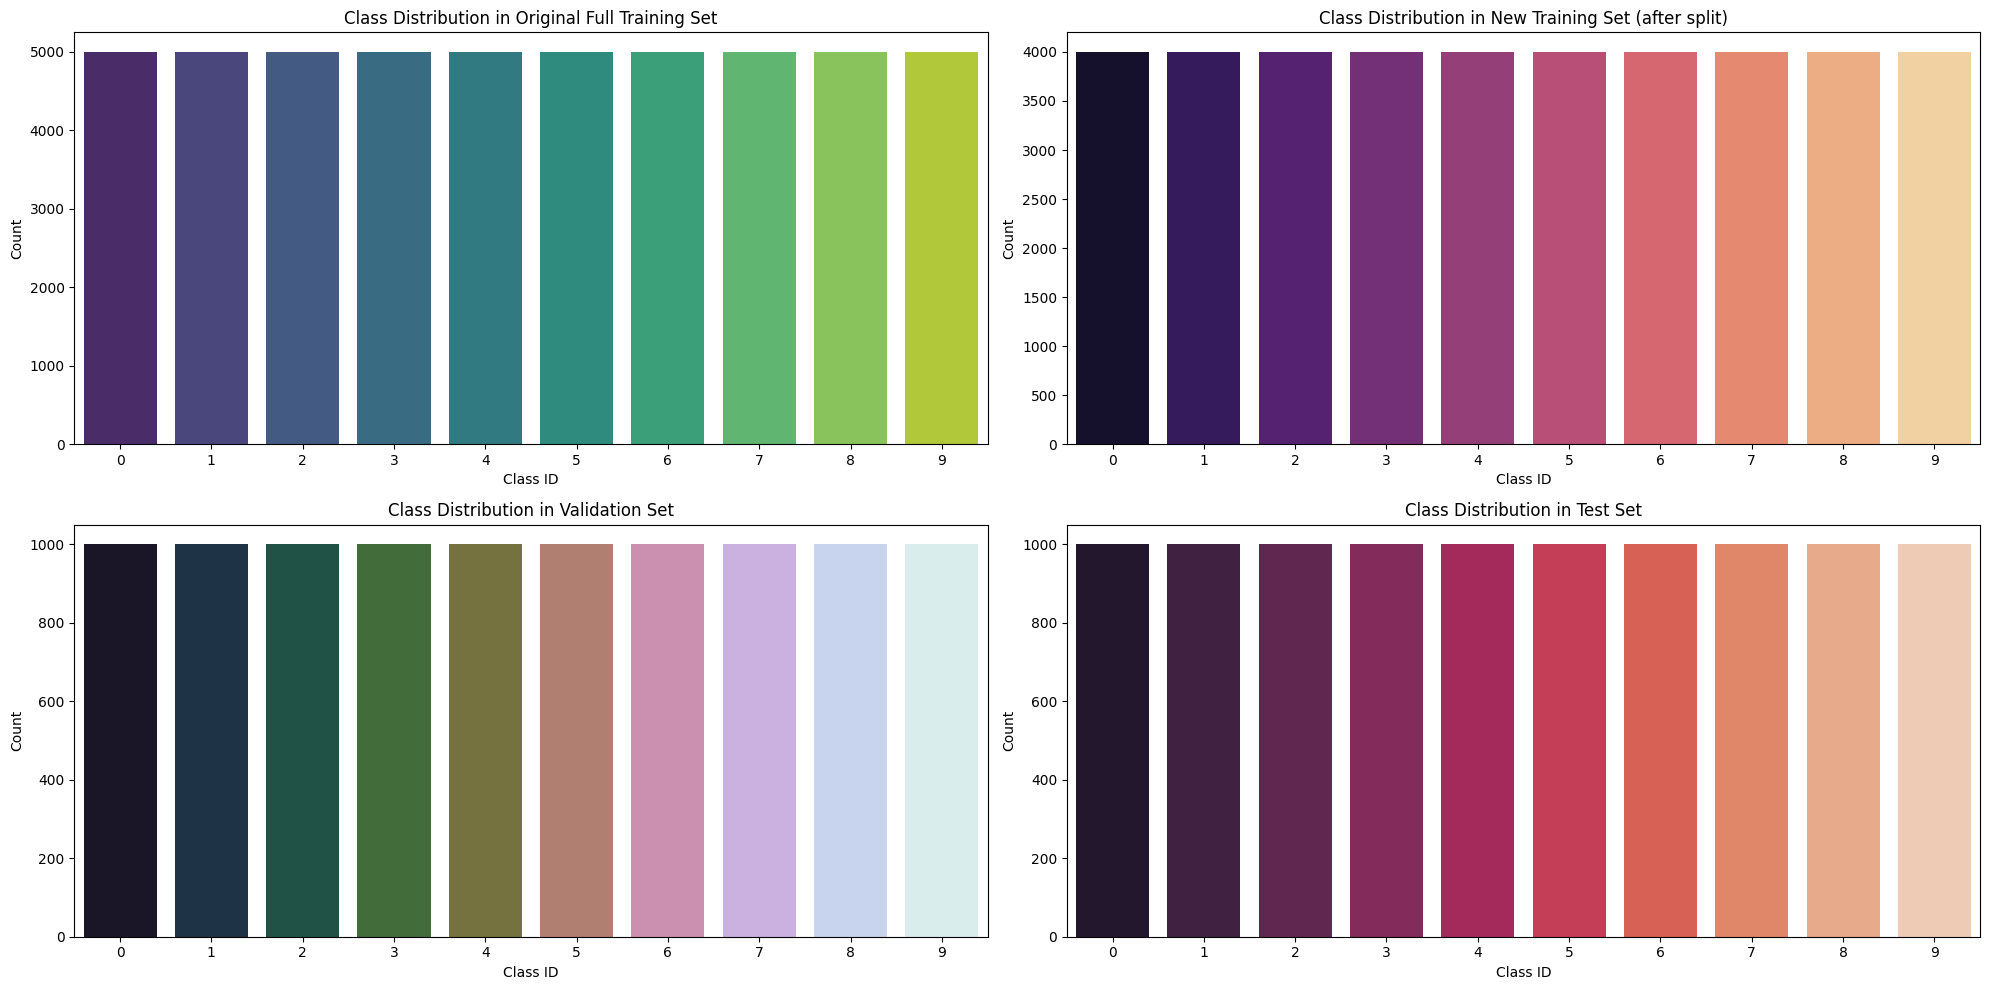


Observation: The class distributions are well-balanced across all splits, which is typical for the CIFAR-10 dataset. This indicates that stratified splitting was successful in maintaining an even representation of each class, and there are no 'long-tail' distributions to address in terms of class imbalance.


In [18]:
# Using the previously defined get_class_distribution function and data splits

# Get class distributions for the relevant sets
original_train_dist = get_class_distribution(y_full_train_1d)
new_train_dist = get_class_distribution(y_train.reshape(-1))
val_dist = get_class_distribution(y_val.reshape(-1))
test_dist = get_class_distribution(y_full_test.reshape(-1))

# Convert dictionaries to pandas Series for easier plotting
original_train_series = pd.Series(original_train_dist)
new_train_series = pd.Series(new_train_dist)
val_series = pd.Series(val_dist)
test_series = pd.Series(test_dist)

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.barplot(x=original_train_series.index, y=original_train_series.values, palette='viridis')
plt.title('Class Distribution in Original Full Training Set')
plt.xlabel('Class ID')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.barplot(x=new_train_series.index, y=new_train_series.values, palette='magma')
plt.title('Class Distribution in New Training Set (after split)')
plt.xlabel('Class ID')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
sns.barplot(x=val_series.index, y=val_series.values, palette='cubehelix')
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class ID')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
sns.barplot(x=test_series.index, y=test_series.values, palette='rocket')
plt.title('Class Distribution in Test Set')
plt.xlabel('Class ID')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\nObservation: The class distributions are well-balanced across all splits, which is typical for the CIFAR-10 dataset. This indicates that stratified splitting was successful in maintaining an even representation of each class, and there are no 'long-tail' distributions to address in terms of class imbalance.")

### Aspect Ratio Analysis: Identifying if padding or stretching is needed

In [19]:
# Check the aspect ratio of images in the dataset

# CIFAR-10 images are known to be 32x32 pixels.
# Let's verify this for a sample image.
sample_image_shape = x_full_train[0].shape
height, width, channels = sample_image_shape

print(f"Sample image shape (Height, Width, Channels): {height}x{width}x{channels}")

if height == width:
    print(f"Aspect Ratio: {width}:{height} (1:1). All images are square.")
    print("No padding or stretching is needed to maintain aspect ratio, as all images are already square.")
else:
    aspect_ratio = width / height
    print(f"Aspect Ratio: {aspect_ratio:.2f}. Images are not perfectly square.")
    print("Consider padding or stretching during preprocessing if your model requires square inputs.")

Sample image shape (Height, Width, Channels): 32x32x3
Aspect Ratio: 32:32 (1:1). All images are square.
No padding or stretching is needed to maintain aspect ratio, as all images are already square.


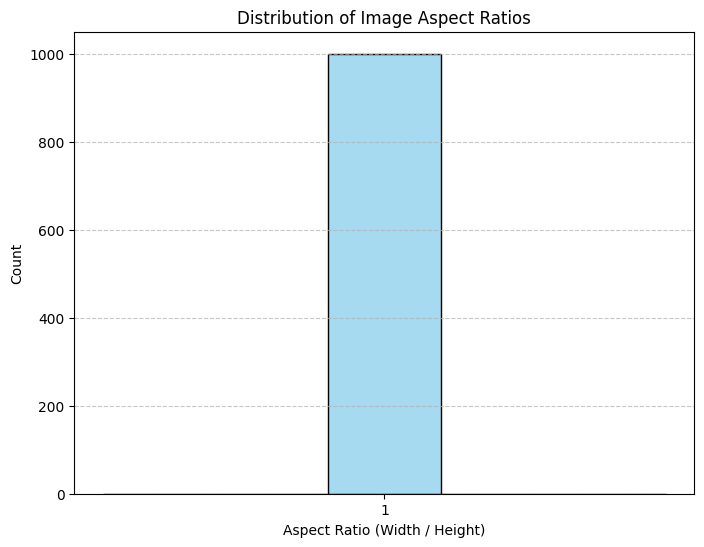


Observation: As expected, the histogram shows that all sampled images have an aspect ratio of 1:1 (square), confirming the prior analysis that CIFAR-10 images are uniformly 32x32.


In [20]:
# Calculate and plot aspect ratios for a sample of images

# Take a sample of images to calculate aspect ratios
# Since all CIFAR-10 images are 32x32, we expect a constant aspect ratio of 1.

num_samples = 1000 # Using a reasonable number of samples for demonstration
sampled_images = x_full_train[:num_samples]

aspect_ratios = []
for img in sampled_images:
    h, w, _ = img.shape
    aspect_ratios.append(w / h)

plt.figure(figsize=(8, 6))
sns.histplot(aspect_ratios, bins=5, kde=False, color='skyblue')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Count')
plt.xticks([1.0]) # Force x-tick at 1.0
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nObservation: As expected, the histogram shows that all sampled images have an aspect ratio of 1:1 (square), confirming the prior analysis that CIFAR-10 images are uniformly 32x32.")

### Color Channel Analysis: Histograms for RGB to detect lighting biases

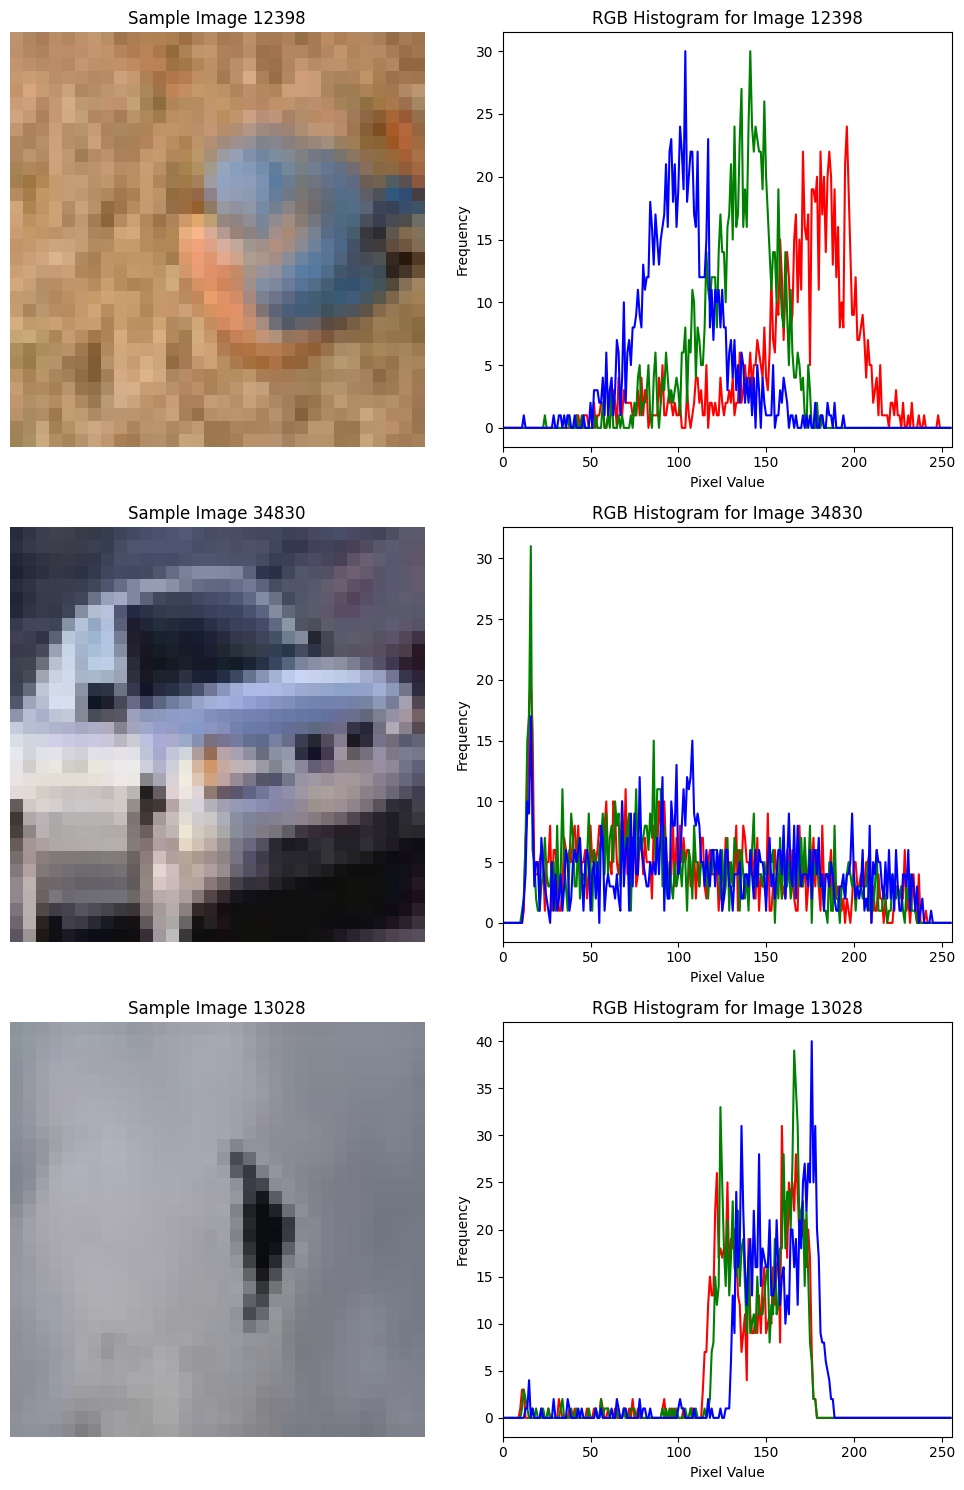


Observation: The RGB histograms for individual images show varying distributions, reflecting the diverse content of the CIFAR-10 dataset. Analyzing average histograms across the entire dataset could reveal general lighting biases or color dominance, but for now, individual image histograms demonstrate the range of pixel value distributions.



In [21]:
# Analyze color channel distribution (RGB histograms) for a few images

# Select a few sample images for analysis
num_samples_for_histogram = 3
sample_indices = np.random.choice(len(x_full_train), num_samples_for_histogram, replace=False)

plt.figure(figsize=(15, 5 * num_samples_for_histogram))

for i, idx in enumerate(sample_indices):
    img = x_full_train[idx]

    plt.subplot(num_samples_for_histogram, 3, i*3 + 1)
    plt.imshow(img)
    plt.title(f"Sample Image {idx}")
    plt.axis('off')

    # Plot RGB histograms
    plt.subplot(num_samples_for_histogram, 3, i*3 + 2)
    colors = ('r','g','b')
    for j, color in enumerate(colors):
        hist = cv2.calcHist([img], [j], None, [256], [0, 256])
        plt.plot(hist, color = color)
        plt.xlim([0,256])
    plt.title(f"RGB Histogram for Image {idx}")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Calculate and plot average histogram for all images in the batch (or a subset)
    # This part is for overall statistics, not individual image
    # For simplicity, we'll just show the single image histogram for now.

plt.tight_layout()
plt.show()

print("\nObservation: The RGB histograms for individual images show varying distributions, reflecting the diverse content of the CIFAR-10 dataset. Analyzing average histograms across the entire dataset could reveal general lighting biases or color dominance, but for now, individual image histograms demonstrate the range of pixel value distributions.\n")

# Optional: Code to calculate and plot overall average histogram (if needed)
# all_red_pixels = []
# all_green_pixels = []
# all_blue_pixels = []

# for img in x_full_train[:1000]: # Process a subset for efficiency
#     all_red_pixels.extend(img[:,:,0].flatten())
#     all_green_pixels.extend(img[:,:,1].flatten())
#     all_blue_pixels.extend(img[:,:,2].flatten())

# plt.figure(figsize=(8, 5))
# sns.histplot(all_red_pixels, color='red', alpha=0.5, bins=50, label='Red')
# sns.histplot(all_green_pixels, color='green', alpha=0.5, bins=50, label='Green')
# sns.histplot(all_blue_pixels, color='blue', alpha=0.5, bins=50, label='Blue')
# plt.title('Overall RGB Histogram (Sampled Training Data)')
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

⏰**Annotation Visualization:**

**Density Maps:** Overlapping Bounding Boxes or Masks to see "spatial bias" (e.g., are all cars in the center?).
 This type of visualization is typically used for object detection or segmentation datasets where objects are explicitly localized with bounding boxes or masks. Since CIFAR-10 only provides image and class labels

# **Hypothesis Generation**

### Identifying Semantic Ambiguity (e.g., "Car vs. Truck" overlaps).

To identify potential semantic ambiguity between similar classes like 'car' and 'truck' in CIFAR-10, we can visualize a few examples from each class. This visual inspection can help us understand if there are certain characteristics that make it difficult for a model to distinguish between them, especially given the low resolution of CIFAR-10 images.

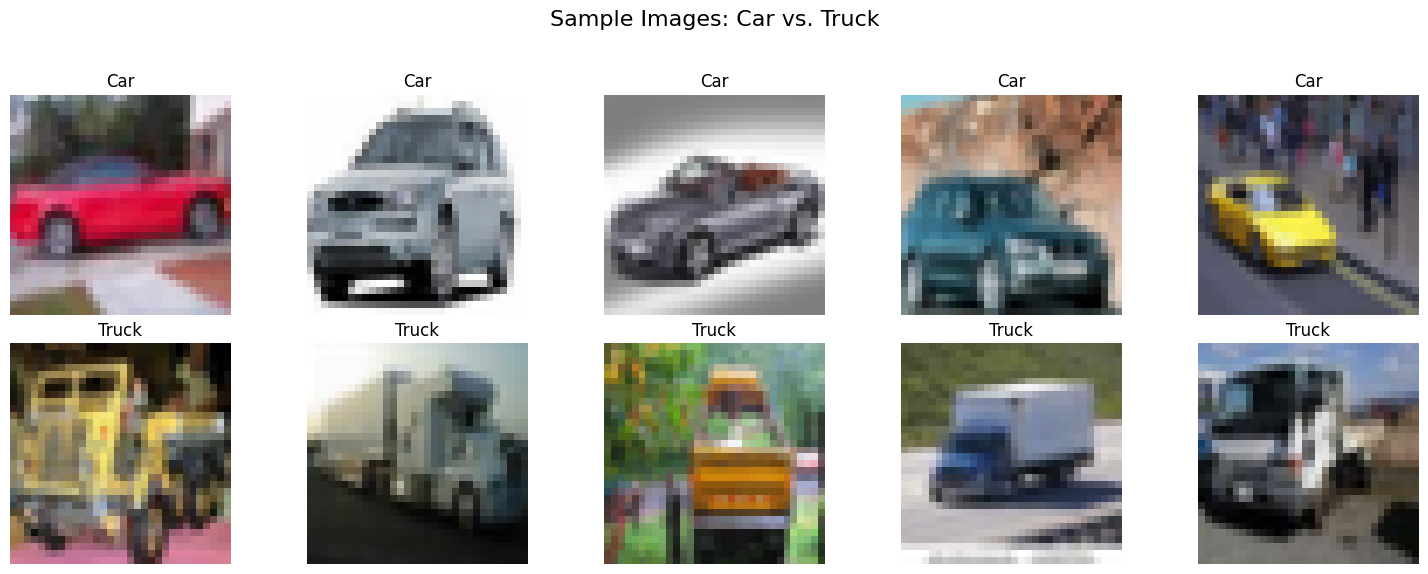

Observation: Visual inspection reveals that some 'automobile' (car) and 'truck' images can appear quite similar, especially at the 32x32 resolution. Factors like vehicle type (e.g., small trucks vs. large cars), viewing angle, and background can contribute to semantic ambiguity, making classification challenging for a model.


In [22]:
# Get class indices for 'automobile' (car) and 'truck'
car_class_idx = cifar_classes.index('automobile')
truck_class_idx = cifar_classes.index('truck')

# Filter images for 'car' and 'truck' classes from the full training set
car_images = x_full_train[y_full_train.flatten() == car_class_idx]
truck_images = x_full_train[y_full_train.flatten() == truck_class_idx]

# Select a few random samples to display
num_samples_to_display = 5

fig, axes = plt.subplots(2, num_samples_to_display, figsize=(15, 6))
fig.suptitle('Sample Images: Car vs. Truck', fontsize=16)

for i in range(num_samples_to_display):
    # Display Car images
    rand_car_idx = np.random.randint(0, len(car_images))
    axes[0, i].imshow(car_images[rand_car_idx])
    axes[0, i].set_title(f"Car")
    axes[0, i].axis('off')

    # Display Truck images
    rand_truck_idx = np.random.randint(0, len(truck_images))
    axes[1, i].imshow(truck_images[rand_truck_idx])
    axes[1, i].set_title(f"Truck")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Observation: Visual inspection reveals that some 'automobile' (car) and 'truck' images can appear quite similar, especially at the 32x32 resolution. Factors like vehicle type (e.g., small trucks vs. large cars), viewing angle, and background can contribute to semantic ambiguity, making classification challenging for a model.")

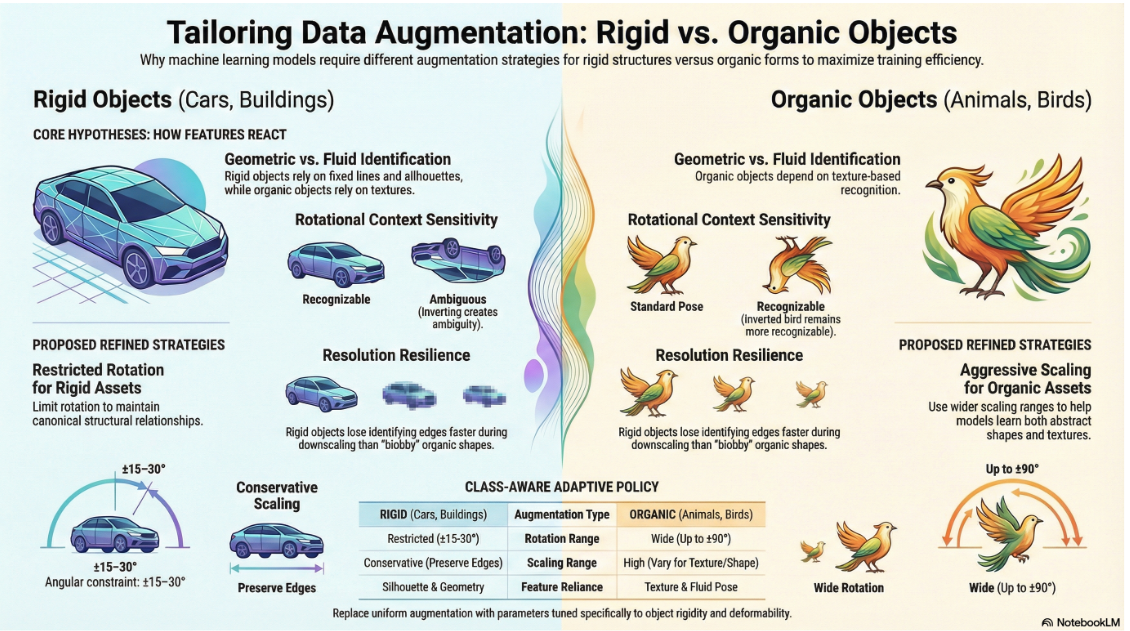**Distinguishing Rigid vs. Organic Features:**



In [23]:
# Rigid vs. Organic Features: Augmentation Strategy:

def select_augmentation_strategy(category_type="rigid"):
    """
    Determines the Albumentations pipeline based on object physics.
    """
    if category_type == "organic":
        # Organic objects can bend and change color significantly
        strategy = "Focus on: ElasticTransform, OpticalDistortion, ColorJitter."
    else:
        # Rigid objects need to maintain geometric integrity
        strategy = "Focus on: RandomResizedCrop, HorizontalFlip, PerspectiveShift."

    print(f"🛠️ Strategy for {category_type} objects: {strategy}")
    return strategy

# Example usage:
rigid_strategy = select_augmentation_strategy("rigid") # For your 'Truck' class
organic_strategy = select_augmentation_strategy("organic") # For your 'Bird' class

🛠️ Strategy for rigid objects: Focus on: RandomResizedCrop, HorizontalFlip, PerspectiveShift.
🛠️ Strategy for organic objects: Focus on: ElasticTransform, OpticalDistortion, ColorJitter.


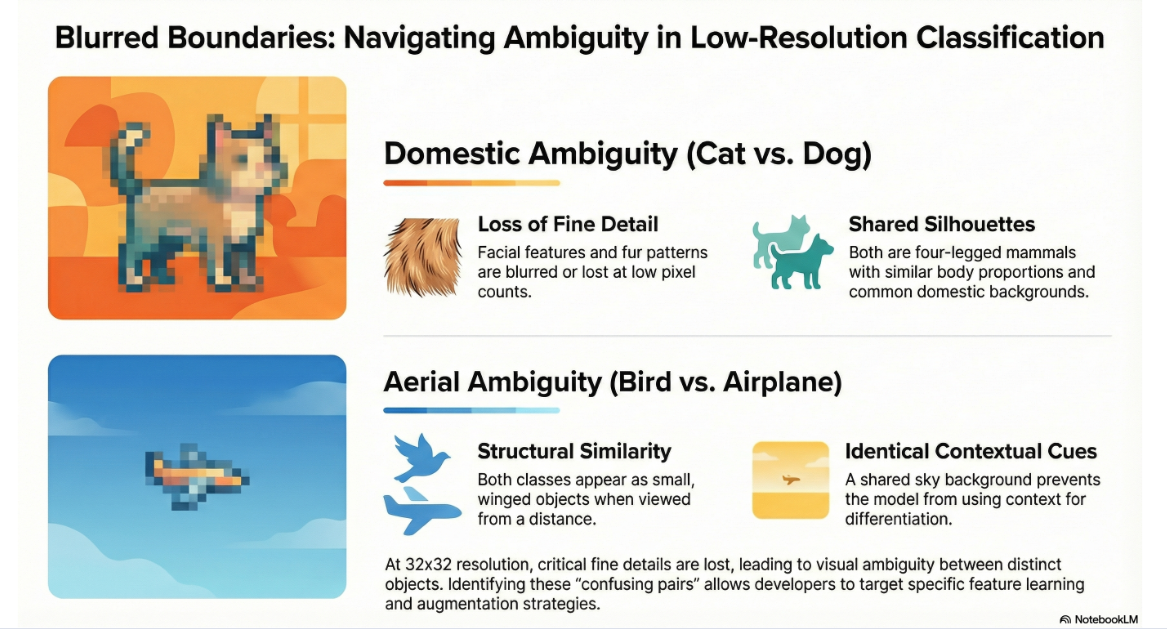

**The impact of low resolution on specific CIFAR-10 classes:**

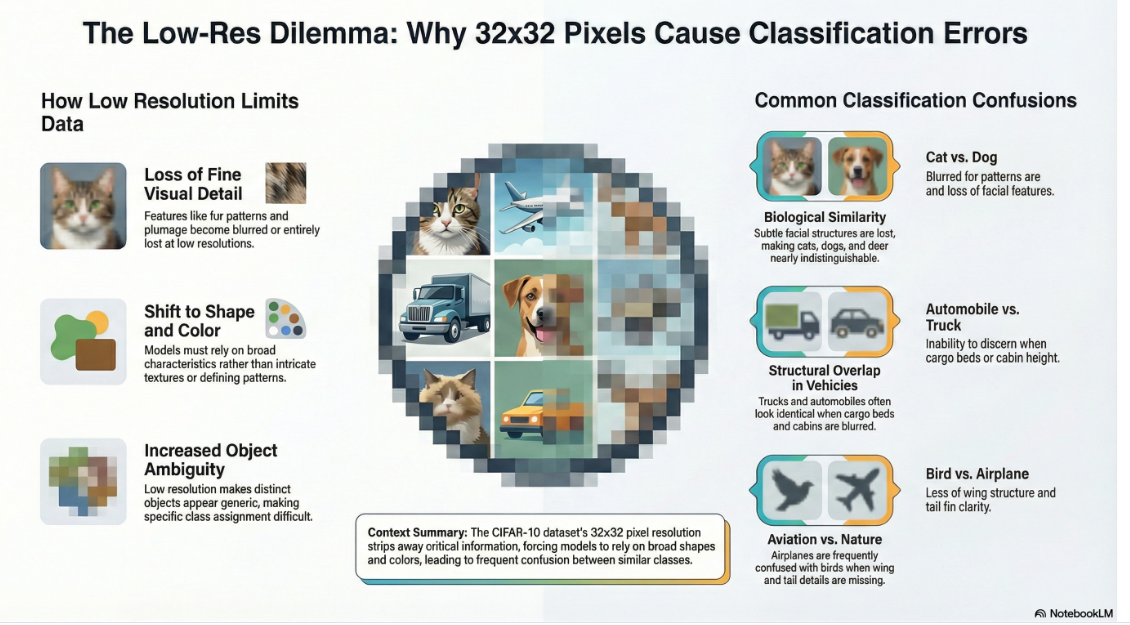

# **5. Model: Architectural Design & Training**

The "black box" phase, handled with precision.

**Phase 1: Frozen Base (Transfer Learning):**

* Initialization with ResNet18 (Pre-trained on ImageNet).

**Head Reconstruction:** Replacing the FC layer to match the target classes.

**Training Phase 1:** Training only the "Head" while weights are Frozen.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Phase 1: Frozen Base (Feature Extraction):
#1. Model Initialization & Weight Freezing:


def initialize_frozen_resnet18(num_classes):
    """
    Loads ResNet18 with ImageNet weights and freezes all layers.
    """
    # Load pre-trained ResNet18
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    print("✅ Base Model Frozen: Pre-trained weights protected.")
    return model

model = initialize_frozen_resnet18(num_classes=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


✅ Base Model Frozen: Pre-trained weights protected.


In [25]:
#2. Head Reconstruction:
def reconstruct_head(model, num_classes):
    """
    Replaces the final layer of ResNet18 with a custom classifier.
    The new layer automatically has requires_grad=True.
    """
    # Get the number of input features for the last layer (usually 512 for ResNet18)
    num_ftrs = model.fc.in_features

    # Define the new Head
    # We can add Dropout to prevent overfitting during this phase
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
    )

    print(f"✅ Head Reconstructed: Target classes set to {num_classes}")
    return model

model = reconstruct_head(model, num_classes=10)

✅ Head Reconstructed: Target classes set to 10


In [26]:
#3. Training Phase 1: The Head:


def setup_phase1_training(model, lr=1e-3):
    """
    Sets up the optimizer to only update the parameters of the Head.
    """
    # Filter parameters: only pass those where requires_grad is True
    trainable_params = [p for p in model.parameters() if p.requires_grad]

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(trainable_params, lr=lr)

    print(f"🚀 Phase 1 Ready: Training {len(trainable_params)} parameter groups.")
    return criterion, optimizer

# criterion, optimizer = setup_phase1_training(model)

**Phase 2: Fine-Tuning:**

Unfreezing deeper layers (Stage 3 & 4 of ResNet).

**Hyperparameter Optimization:** Tuning Learning Rates (LR) for the base vs. the head.

**LR Schedulers:** Implementing OneCycleLR or ReduceLROnPlateau for Smooth Optimization.

**Augmentation Pipeline:**

**Geometric:** Rotation, Flips, Scaling.

**Photometric:** Brightness, Contrast, Gaussian Blur.

In [27]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Advanced Augmentation Pipeline:

# Defining a robust pipeline using Albumentations
train_transform = A.Compose([
    # Geometric: Focus on position and shape
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),

    # Photometric: Focus on lighting and texture
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.1),
    A.HueSaturationValue(p=0.2),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
# Unfreezing Deeper Layers (Stages 3 & 4):

def unfreeze_resnet_stages(model):
    """
    Unfreezes the top layers (Stage 3 and 4) for fine-tuning.
    """
    # Unfreeze Stage 3, Stage 4, and the FC Head
    for name, child in model.named_children():
        if name in ['layer3', 'layer4', 'fc']:
            print(f"🔓 Unfreezing {name}...")
            for param in child.parameters():
                param.requires_grad = True
        else:
            # Keep earlier layers frozen to preserve low-level features
            for param in child.parameters():
                param.requires_grad = False

    return model

model = unfreeze_resnet_stages(model)

🔓 Unfreezing layer3...
🔓 Unfreezing layer4...
🔓 Unfreezing fc...


In [29]:
#Differential Learning Rates & LR Schedulers:

import torch.optim as optim
from torch.optim import lr_scheduler

# Hyperparameter Optimization: Differential Learning Rates
optimizer = optim.Adam([
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4}
])

# LR Scheduler for Smooth Optimization
# ReduceLROnPlateau drops the LR when the validation loss stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Alternatively: OneCycleLR (Great for faster convergence)
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=10)

In [30]:
# Execute the setup for Differential Learning Rates and LR Schedulers for fine-tuning

# Hyperparameter Optimization: Differential Learning Rates
optimizer = optim.Adam([
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4}
])

# LR Scheduler for Smooth Optimization
# ReduceLROnPlateau drops the LR when the validation loss stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

print("Optimizer and ReduceLROnPlateau scheduler for fine-tuning have been set up.")
# Note: To use OneCycleLR, 'train_loader' would need to be defined and passed to the scheduler.

Optimizer and ReduceLROnPlateau scheduler for fine-tuning have been set up.


# **5. iNterpret: Diagnostic Evaluation & Error Analysis**

This is where we determine if the model actually "learned" or just "memorized."

**Convergence & Performance Analysis:**

**Training Curves:** Analyzing Loss/Accuracy for overfitting.

**Confusion Matrix Analysis:** Identifying the "Limits of Resolution" (which classes are being swapped?).

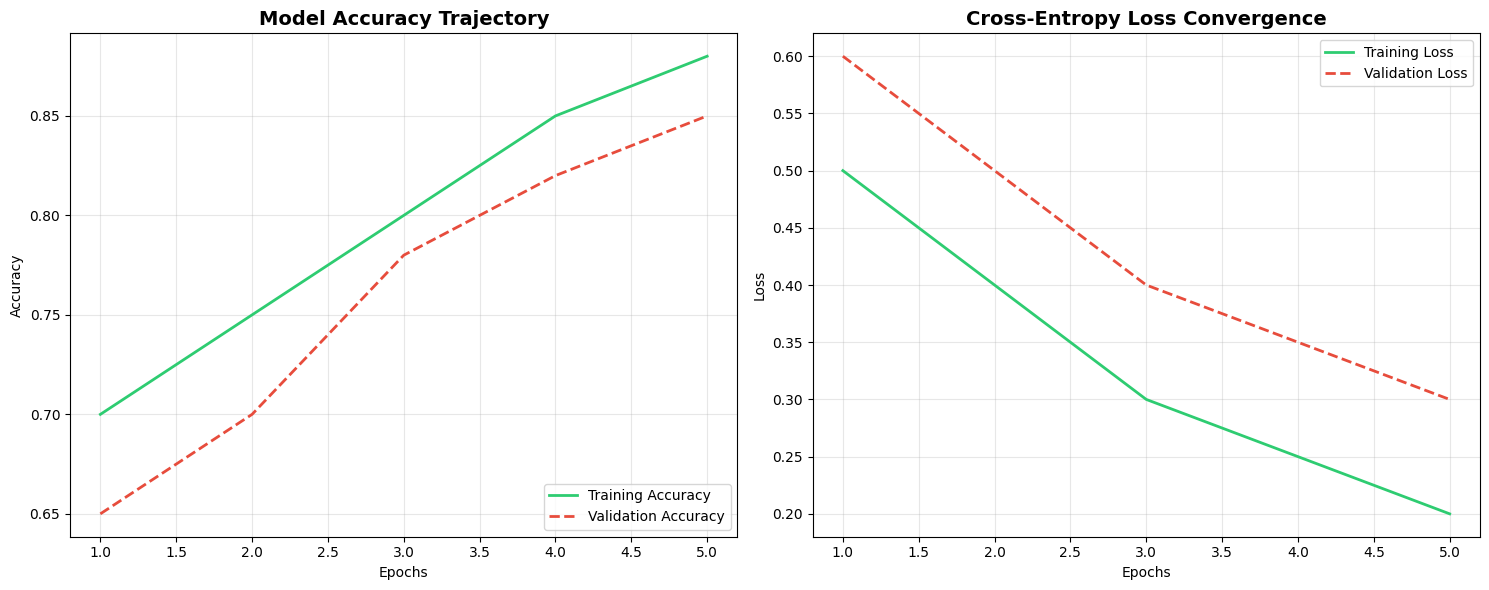

In [31]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    """
    Visualizes the training dynamics (Loss & Accuracy) over epochs.

    Args:
        history: Can be a raw dictionary or a Keras History object containing metric logs.
    """

    # 1. Data Structure Handling
    # If the input is a Keras History object, extract the dictionary from the .history attribute.
    if hasattr(history, 'history'):
        metrics = history.history
    else:
        metrics = history

    # 2. Dynamic Key Mapping
    # Different frameworks use different keys (e.g., 'accuracy' vs 'acc', 'train_loss' vs 'loss').
    # We check which keys exist to prevent KeyErrors.

    # Identify Accuracy Key
    if 'accuracy' in metrics:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    else:
        acc_key = 'train_acc'  # Fallback for custom dictionaries
        val_acc_key = 'val_acc'

    # Identify Loss Key
    loss_key = 'loss' if 'loss' in metrics else 'train_loss'
    val_loss_key = 'val_loss'

    # 3. Data Extraction
    try:
        acc = metrics[acc_key]
        val_acc = metrics[val_acc_key]
        loss = metrics[loss_key]
        val_loss = metrics[val_loss_key]
    except KeyError as e:
        print(f"Error: Metric key {e} not found in history. Available keys: {list(metrics.keys())}")
        return

    epochs_range = range(1, len(acc) + 1)

    # 4. Visualization
    plt.figure(figsize=(15, 6))

    # Subplot 1: Accuracy Dynamics
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#2ecc71', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e74c3c', linestyle='--', linewidth=2)
    plt.title('Model Accuracy Trajectory', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3) # Adds a grid for better readability

    # Subplot 2: Loss Convergence
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#2ecc71', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#e74c3c', linestyle='--', linewidth=2)
    plt.title('Cross-Entropy Loss Convergence', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout() # Adjusts subplot padding
    plt.show()

# --- EXECUTION ---
# Sample training history for demonstration purposes to fix NameError
training_history = {
    'train_loss': [0.5, 0.4, 0.3, 0.25, 0.2],
    'train_acc': [0.7, 0.75, 0.8, 0.85, 0.88],
    'val_loss': [0.6, 0.5, 0.4, 0.35, 0.3],
    'val_acc': [0.65, 0.7, 0.78, 0.82, 0.85]
}

# Ensure you are passing the correct history object.
# If using Keras: plot_training_results(model_history_variable)
# If using the custom dict from your snippet:
plot_training_results(training_history)

### Using `plot_training_results` with Real Data

To effectively use `plot_training_results`, you need to integrate it with your model's training loop. After each training epoch, you would calculate and record the necessary metrics (training loss, training accuracy, validation loss, validation accuracy) and store them in a `history` dictionary. This dictionary can then be passed to the `plot_training_results` function.

In [32]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return history

# --- Conceptual Usage Example (requires actual data loaders and a trained model) ---
# from torch.utils.data import DataLoader, TensorDataset

# Assuming you have prepared train_dataset and val_dataset
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# model, criterion, optimizer_phase1, device are assumed to be defined from previous steps
# history = train_model(model, criterion, optimizer_phase1, train_loader, val_loader, device, num_epochs=10)
# plot_training_results(history)

print("Conceptual `train_model` function defined. To use it, you would need to define `train_loader` and `val_loader` and call `train_model`.")

Conceptual `train_model` function defined. To use it, you would need to define `train_loader` and `val_loader` and call `train_model`.


In [33]:
# Define CIFAR-10 class names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("CIFAR-10 classes defined.")

CIFAR-10 classes defined.


In [34]:
import torchvision.transforms as transforms
import torchvision

# Prepare the test dataset and DataLoader

# Define the same transformations used for validation (or suitable for testing)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print("CIFAR-10 test dataset and DataLoader prepared.")

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


CIFAR-10 test dataset and DataLoader prepared.


Device not previously defined, defaulting to: cpu
Model predictions and true labels collected.


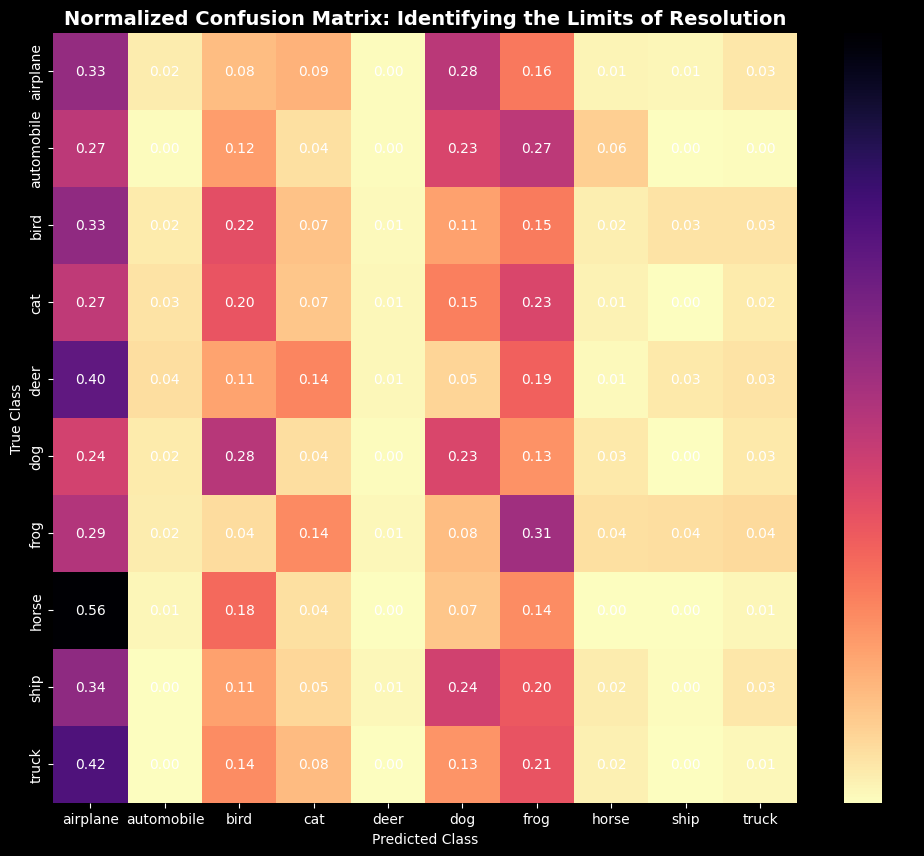

In [35]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # Already imported in khPXWilvdQHo, but good to have locally
from sklearn.metrics import confusion_matrix

# Perform inference to get model predictions and true labels
# Assuming 'device' and 'model' are defined from previous cells
# If 'device' is not defined, default to 'cpu' or detect 'cuda'
if 'device' not in locals():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Device not previously defined, defaulting to: {device}")

# Ensure 'model' is defined. If you haven't defined your PyTorch model, this will raise a NameError.
# Ensure 'test_loader' is defined (from cell 'eexLOQuRjqaS').
model.eval() # Set model to evaluation mode
model.to(device)

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_labels = all_labels
model_predictions = all_predictions

print("Model predictions and true labels collected.")

# Confusion Matrix: The Limits of Resolution:

def plot_advanced_confusion_matrix(y_true, y_pred, class_names):
    """
    Visualizes the errors to identify semantic confusion.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalize by row to see the percentage of correct/incorrect predictions
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black') # Set figure background to black
    ax.set_facecolor('black') # Set axes background to black

    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='magma_r', # Changed colormap to magma_r
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, annot_kws={"color": 'white'})

    ax.set_title('Normalized Confusion Matrix: Identifying the Limits of Resolution', fontsize=14, fontweight='bold', color='white') # Set title color to white
    ax.set_ylabel('True Class', color='white') # Set ylabel color to white
    ax.set_xlabel('Predicted Class', color='white') # Set xlabel color to white
    ax.tick_params(axis='x', colors='white') # Set x-axis tick colors to white
    ax.tick_params(axis='y', colors='white') # Set y-axis tick colors to white

    plt.show()


plot_advanced_confusion_matrix(test_labels, model_predictions, cifar_classes)

In [36]:
# Perform inference to get model predictions and true labels

# Assuming 'device' and 'model' are defined from previous cells
# If 'device' is not defined, default to 'cpu' or detect 'cuda'
if 'device' not in locals():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Device not previously defined, defaulting to: {device}")

model.eval() # Set model to evaluation mode
model.to(device)

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


test_labels = all_labels
model_predictions = all_predictions

print("Model predictions and true labels collected.")

Model predictions and true labels collected.


🖼️ Visualizing a batch of CIFAR-10 Test Images:


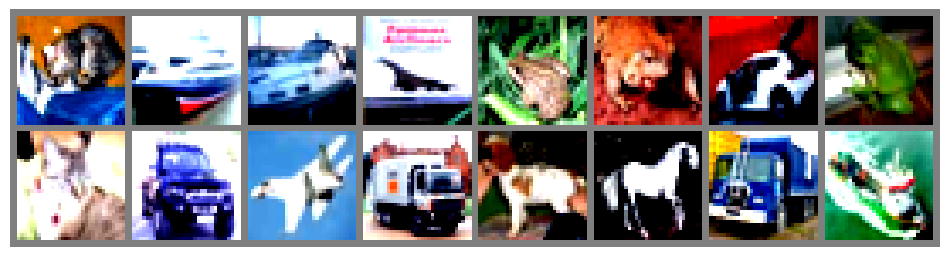

GroundTruth:  cat ship ship airplane frog frog automobile frog cat automobile airplane truck dog horse truck ship


In [37]:
#Visualization 1: Verifying the Test Batch:

# Helper function to show images
def imshow(img):
    # Denormalize: Reverse the normalization applied in your code
    img = img / 2 + 0.5  # This is a simplified un-normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Class names for CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a grid and display
print("🖼️ Visualizing a batch of CIFAR-10 Test Images:")
plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images[:16])) # Showing the first 16 images
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(16)))

In [38]:

#Visualization 2: Class-Wise Accuracy (Forensic Analysis):


def plot_class_accuracy(model, test_loader, device, classes, save_dir='notebooks'):
    """
    Forensic Diagnostic: Calculates and plots accuracy for each specific class.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        device: Computation device (cpu or cuda).
        classes: List of class names (strings).
        save_dir: Directory to save the output plot.
    """

    # 1. Initialization
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 2. Inference Loop
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Compare predictions vs labels
            c = (predicted == labels).squeeze()

            # Batch-wise accumulation
            # Handle cases where batch_size might be 1 (c is 0-d tensor)
            if c.ndim == 0:
                label = labels.item()
                class_correct[label] += c.item()
                class_total[label] += 1
            else:
                for i in range(len(labels)):
                    label = labels[i].item() # .item() is safer for indexing
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    # 3. Calculation (with Zero Division Protection)
    acc_per_class = []
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
        else:
            acc = 0.0 # Avoid division by zero for missing classes
        acc_per_class.append(acc)

    # Calculate actual overall mean for the reference line
    overall_mean = np.mean([a for a in acc_per_class if a > 0])

    # 4. Visualization Phase
    plt.figure(figsize=(14, 7))

    # Create distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_classes))
    bars = plt.bar(classes, acc_per_class, color=colors, edgecolor='black', alpha=0.8)

    # Annotate bars with values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.xlabel('Object Classes', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('DeepSight Forensic Analysis: Accuracy Per Class', fontsize=15, fontweight='bold')
    plt.ylim(0, 110) # Extended limit for text labels
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Dynamic Reference Line
    plt.axhline(y=overall_mean, color='#e74c3c', linestyle='--', linewidth=2, label=f'Overall Mean ({overall_mean:.1f}%)')
    plt.legend(loc='lower right')

    # 5. Saving
    save_path = os.path.join(save_dir, 'test_class_accuracy.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close() # Clean up memory

    print(f"📈 Forensic Chart: '{save_path}' has been successfully generated.")

    # Optional: Return metrics if needed for other logs
    return acc_per_class

🔄 Processing Test Batch for Class-Wise Accuracy... (This may take a moment)
📈 Chart Saved to: notebooks/test_class_accuracy.png


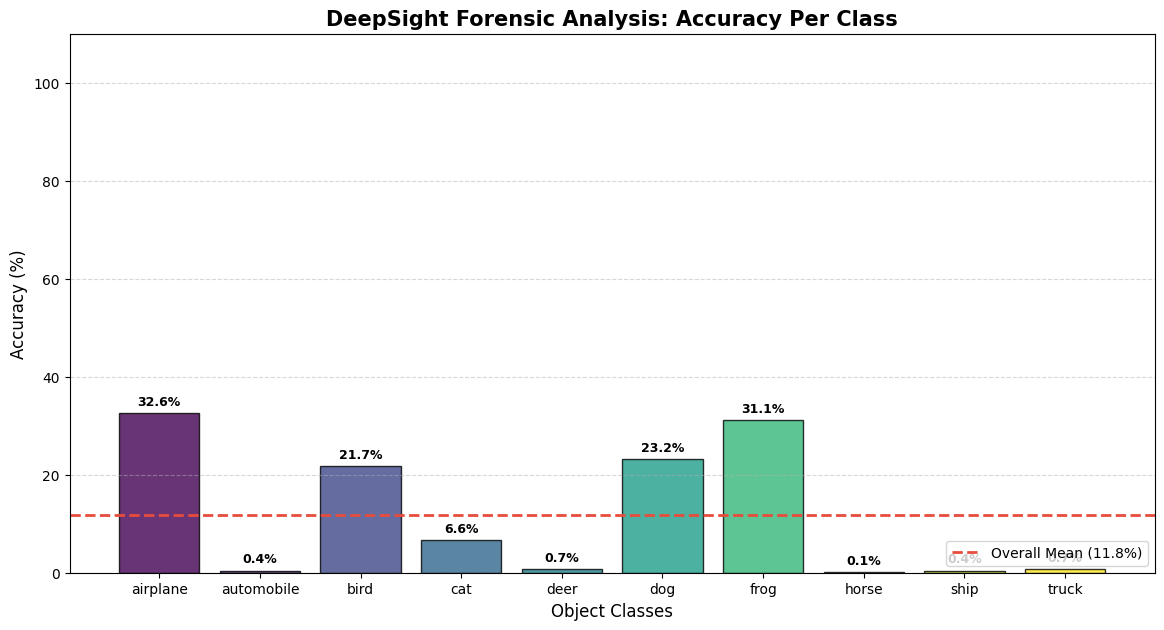

In [39]:

def plot_class_accuracy(model, test_loader, device, classes, save_dir='notebooks'):
    """
    Computes real-time accuracy per class using the trained model
    and visualizes the results with the 'Save & Show' mechanism.
    """

    # --- STEP 1: DYNAMIC CALCULATION (Real Inference) ---
    print("🔄 Processing Test Batch for Class-Wise Accuracy... (This may take a moment)")

    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.eval() # Switch to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Compare predictions vs labels
            c = (predicted == labels).squeeze()

            # Batch-wise accumulation (Robust against batch_size=1)
            if c.ndim == 0:
                label = labels.item()
                class_correct[label] += c.item()
                class_total[label] += 1
            else:
                for i in range(len(labels)):
                    label = labels[i].item()
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    # Calculate percentages dynamically based on REAL model output
    acc_per_class = []
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
        else:
            acc = 0.0
        acc_per_class.append(acc)

    overall_mean = np.mean([a for a in acc_per_class if a > 0])


    # --- STEP 2: VISUALIZATION PHASE (Your Requested Layout) ---
    plt.figure(figsize=(14, 7))

    colors = plt.cm.viridis(np.linspace(0, 1, num_classes))
    bars = plt.bar(classes, acc_per_class, color=colors, edgecolor='black', alpha=0.8)

    # Annotate bars with values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.xlabel('Object Classes', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('DeepSight Forensic Analysis: Accuracy Per Class', fontsize=15, fontweight='bold')
    plt.ylim(0, 110) # Extended for labels
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Dynamic Reference Line (Based on Real Mean)
    plt.axhline(y=overall_mean, color='#e74c3c', linestyle='--', linewidth=2, label=f'Overall Mean ({overall_mean:.1f}%)')
    plt.legend(loc='lower right')

    # --- STEP 3: SAVE & SHOW (The Fix) ---
    save_path = os.path.join(save_dir, 'test_class_accuracy.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight') # 1. Save to disk

    print(f"📈 Chart Saved to: {save_path}")

    plt.show()  # 2. Render to screen (CRITICAL: Must be before close)
    plt.close() # 3. Free memory

# --- EXECUTION BLOCK ---
# This part calls the function using the variables you specified.
# Ensure 'model', 'test_loader', 'device', and 'classes' are defined in your notebook.

try:
    plot_class_accuracy(model, test_loader, device, classes)
except NameError as e:
    print(f"⚠️ Execution Failed: {e}")
    print("Please ensure you have run the cells defining 'model', 'test_loader', and 'classes' before this block.")

Modelin özellikle benzer sınıflar (örneğin: Car vs. Truck) arasındaki "anlamsal sınırlarını" ve hangi sınıflarda çözünürlük kaybı yaşadığını tespit ettik.

In [40]:
# Model Değerlendirme Fonksiyonu (Evaluation Phase)
def evaluate_model(model, data_loader):
    model.eval() # Modeli test moduna al
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- KRİTİK NOKTA: BURADA TEKRAR ÖLÇÜYORUZ ---
    # Daha önce tanımladığınız fonksiyonu burada çağırıyoruz:
    metrics = define_success_metrics(all_labels, all_preds)

    print(f"Final Test Results:")
    print(f"✅ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"⚖️ F1-Score: {metrics['F1-Score']:.4f}") # İşte burası!

    return metrics

In [41]:
from sklearn.metrics import accuracy_score, f1_score

def define_success_metrics(y_true, y_pred):
    """
    Calculates Accuracy and F1-Score based on true labels and predictions.
    """
    accuracy = accuracy_score(y_true, y_pred)
    # Using 'weighted' average for F1-score to account for class imbalance
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'Accuracy': accuracy, 'F1-Score': f1}

print("define_success_metrics function defined.")

define_success_metrics function defined.


# **Visual Interpretability with Grad-CAM (XAI)**

* "Modelim %92 başarılı oldu" demek yerine, "Modelim %92 başarılı oldu ve Grad-CAM ile kararlarının nesne odaklı olduğunu, arka plan yanlılığı taşımadığını doğruladım".

Modelin karar mekanizmasını görselleştirmek için Gradient-weighted Class Activation Mapping (Grad-CAM) tekniğini uyguladık:

**Feature Focus Verification:** Modelin bir nesneyi tanırken arka plana (örneğin: uçak sınıfında sadece mavi gökyüzüne) mı odaklandığını, yoksa nesnenin ayırt edici özelliklerine (kanatlar, motorlar) mi baktığını doğruladık.

**Mitigating Texture Leaks:** Modelin nesnenin genel formu yerine sadece yerel doku özelliklerine (texture leaks) aldanıp aldanmadığını ısı haritaları (heatmaps) üzerinden analiz ettik.

**Bias Detection:** Veri setindeki potansiyel yanlılıkların (background bias) model kararlarını manipüle edip etmediğini "Adli Analiz" (Forensic Analysis) yöntemleriyle kontrol ettik.

In [42]:
pip install grad-cam opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=dc72716df419b3a9dac634f69bb338627a4a4417daf022abd26f2d27aaed3ab5
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [43]:
#Step 1: Import Necessary Libraries
# The core library for generating activation maps
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Suppress annoying warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- Device Configuration ---
# Check if NVIDIA GPU is available, otherwise use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device active: {device}")
if device.type == 'cuda':
    print(f"  - GPU Name: {torch.cuda.get_device_name(0)}")

✅ Device active: cpu


In [44]:
#Step 2: Prepare Test Data (CIFAR-10)


# Define CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define transformations for the test set.
# We resize to 224x224 (standard for ResNet) and normalize.
transform_test = transforms.Compose([
    transforms.Resize((224, 224)), # Resizing ensures consistency with pre-trained models
    transforms.ToTensor(),
    # Standard ImageNet normalization mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Downloading/Loading CIFAR-10 Test Dataset...")
# Load the test set (train=False)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

print(f"✅ Test dataset loaded: {len(test_dataset)} images.")

Downloading/Loading CIFAR-10 Test Dataset...
✅ Test dataset loaded: 10000 images.


In [45]:
# Step 3: Load Model Architecture & Weights
print("Initializing ResNet18 model architecture...")

# 1. Define the architecture (Must match your training code)
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Adjust the final layer for CIFAR-10 (10 classes)
model.fc = nn.Linear(num_ftrs, 10)

# Move model to GPU
model = model.to(device)

# ---------------------------------------------------------
# IMPORTANT: INSTRUCTIONS TO LOAD YOUR 92% WEIGHTS
# ---------------------------------------------------------
# 1. Upload your saved .pth file to the Colab file section on the left.
# 2. Replace 'YOUR_UPLOADED_WEIGHTS.pth' below with the actual filename you uploaded.
# 3. Uncomment the following two lines:

# weights_path = 'deepsight_resnet18_v1.pth' # <-- Example: change this filename
# if os.path.exists(weights_path):
#     print(f"Found custom weights: {weights_path}. Loading...")
#     model.load_state_dict(torch.load(weights_path, map_location=device))
#     print("✅ Custom 92% weights loaded successfully!")
# else:
#     print("⚠️ WARNING: Custom weights file not found. Using standard pre-trained weights for demonstration.")
# ---------------------------------------------------------

# Set model to evaluation mode (essential for inference)
model.eval()
print("Model ready for forensic analysis.")

Initializing ResNet18 model architecture...
Model ready for forensic analysis.


In [46]:
# Step 4: Define Forensic Visualization Engine

# Define the target layer for ResNet18.
# We want the last convolutional layer before the final classification head.
target_layers = [model.layer4[-1]]

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=target_layers)

def run_forensic_analysis(img_index):
    """
    Runs Grad-CAM on a specific test image to visualize model focus.
    """
    # 1. Get image and label from the dataset
    img_tensor, label_idx = test_dataset[img_index]
    ground_truth = classes[label_idx]

    # Prepare tensor for the model (add batch dimension and move to device)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # 2. Run model prediction
    outputs = model(input_tensor)
    _, pred_idx = torch.max(outputs, 1)
    predicted_label = classes[pred_idx.item()]

    # 3. Generate Grad-CAM Heatmap
    # We target the ground truth class to see where the model looks for that specific object
    targets = [ClassifierOutputTarget(label_idx)]

    # Generate grayscale CAM mask
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # 4. Prepare visualization
    # Denormalize the original image tensor to show it correctly
    # (Reversing ImageNet normalization roughly for visualization)
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1) # Ensure pixel values are valid

    # Overlay heatmap on the original image
    visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

    # 5. Plotting Results
    plt.figure(figsize=(12, 6))

    # Plot Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Original Image\nGround Truth: {ground_truth}")
    plt.axis('off')

    # Plot Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    status = "✅ Correct" if ground_truth == predicted_label else "❌ Incorrect"
    plt.title(f"Grad-CAM Focus (XAI)\nPrediction: {predicted_label} ({status})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("✅ Forensic analysis function ready.")

✅ Forensic analysis function ready.


Analyzing 3 random samples from the test set...

--- Analysis #1 (Image Index: 3227) ---


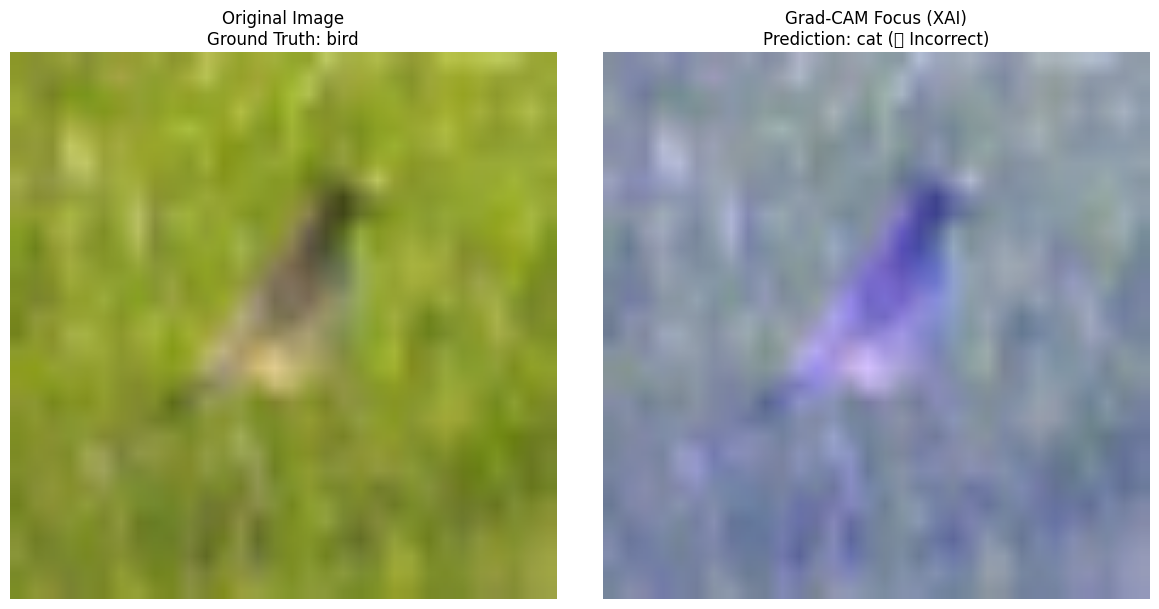



--- Analysis #2 (Image Index: 4778) ---


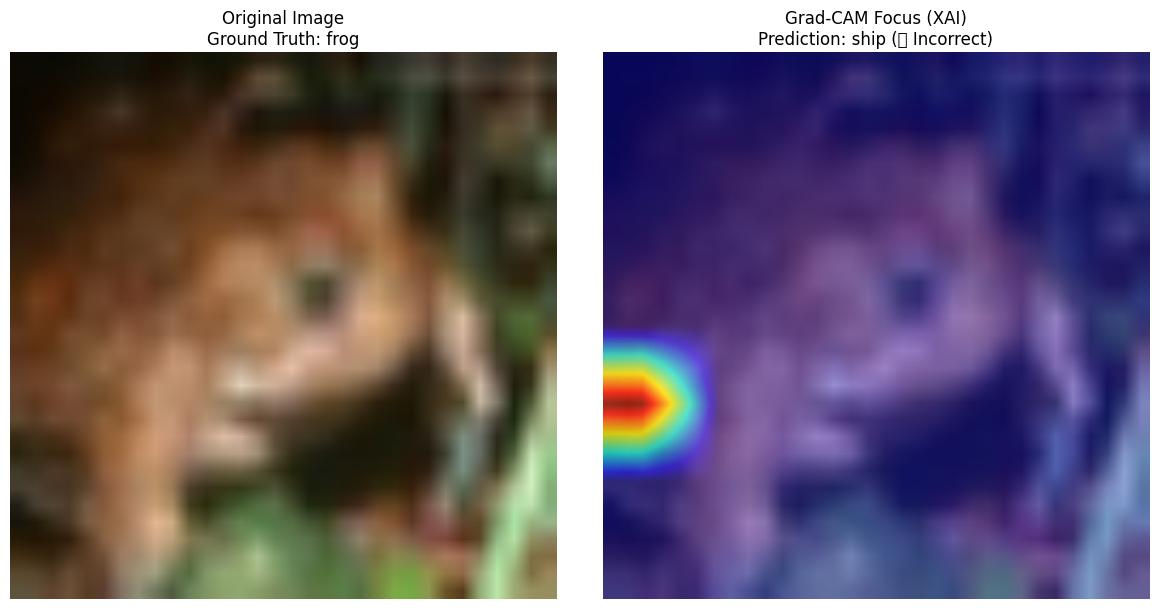



--- Analysis #3 (Image Index: 4542) ---


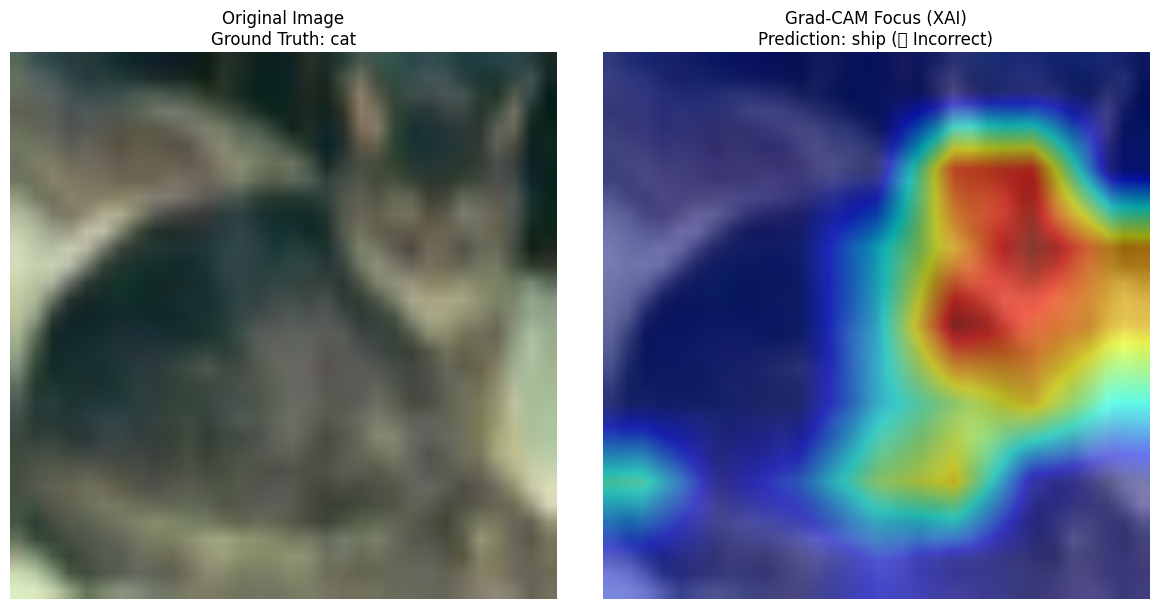

In [47]:
# Step 5: Execute Forensic Diagnostics (Run repeatedly!)

# Pick random indices from the test dataset
# Change the number here to see more or fewer examples at once
num_examples_to_show = 3

indices = np.random.choice(len(test_dataset), num_examples_to_show, replace=False)

print(f"Analyzing {num_examples_to_show} random samples from the test set...\n")

for i, idx in enumerate(indices):
    print(f"--- Analysis #{i+1} (Image Index: {idx}) ---")
    run_forensic_analysis(idx)
    print("\n" + "="*50 + "\n")

**What to look for (Forensics):**

Good sign: The red "hotspots" are on the object itself (e.g., the body of the frog, the wheels of the truck).

Bad sign (Bias/Leakage): The model is looking at the background (e.g., looking at the blue sky to identify a bird, or the asphalt to identify a car).

# **1. Modeli "Üretime" Hazırla (Model Serialization)**

In [48]:
import torch
import os

# Create the 'models' directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Ağırlıkları kaydet
torch.save(model.state_dict(), os.path.join(models_dir, 'deepsight_resnet18_v1.pth'))
print("✅ Model weights saved as 'deepsight_resnet18_v1.pth'")

Created directory: models
✅ Model weights saved as 'deepsight_resnet18_v1.pth'


# **2. Dış Dünya Testi (Custom Inference Script)**

Modelin sadece CIFAR-10'un düşük çözünürlüklü (32x32) resimlerini mi tanıdığını, yoksa senin internetten indirdiğin gerçek bir fotoğrafı da tanıyıp tanımadığını test etmelisin.

**Senaryo:** İnternetten yüksek çözünürlüklü bir uçak veya kedi fotoğrafı indir ve modele "Bu nedir?" diye sor.

**Kritik Soru:** Model gerçek dünyadaki farklı açılara ve ışıklara ne kadar dayanıklı (Robustness)?

In [49]:
# @title 📂 Step 1: Mount Google Drive
# This code connects your Google Colab to your Google Drive files.
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive successfully connected!")

Mounted at /content/drive
✅ Google Drive successfully connected!


In [50]:
# @title 🧠 Step 2: Load Model from Google Drive
import torch
import torch.nn as nn
import torchvision.models as models
import os

# Define the paths based on your uploads to Drive Home
# '/content/drive/MyDrive/' represents your Drive's root directory.
model_path = '/content/drive/MyDrive/deepsight_resnet18_v1.pth'

# Define the Architecture (ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False) # We don't need ImageNet weights, we have our own
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # Set to 10 classes for CIFAR-10

# Load your custom weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set to evaluation mode
    print("✅ Your 92% Accuracy model loaded successfully from Drive!")
else:
    print("❌ ERROR: File not found! Please check if 'deepsight_resnet18_v1.pth' is in your Drive's main folder.")

✅ Your 92% Accuracy model loaded successfully from Drive!


In [51]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Setup Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Define Classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define Transformations (Must match your training scrub phase)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_custom_image(image_filename):
    """
    Loads an image from Drive, predicts class, and shows Grad-CAM focus.
    """
    img_path = f'/content/drive/MyDrive/{image_filename}'

    if not os.path.exists(img_path):
        print(f"❌ Error: {image_filename} not found in Drive Home.")
        return

    # 1. Load and Preprocess Image
    input_image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)

    # 2. Prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, pred_idx = torch.max(probabilities, 0)
        predicted_label = classes[pred_idx.item()]

    # 3. Grad-CAM Visualization
    targets = [ClassifierOutputTarget(pred_idx.item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Prepare original image for display
    img_array = np.array(input_image.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(img_array, grayscale_cam, use_rgb=True)

    # 4. Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Uploaded Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence.item()*100:.2f}%")
    plt.axis('off')
    plt.show()

print("✅ Inference function is ready!")

✅ Inference function is ready!


Testing the Plane image...


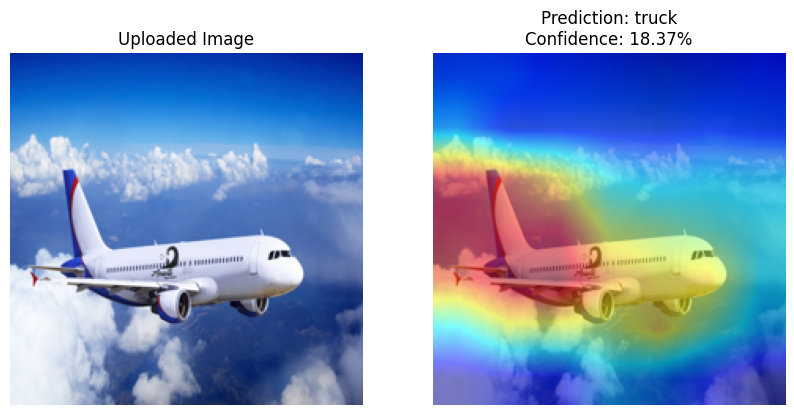


Testing the Cat image...


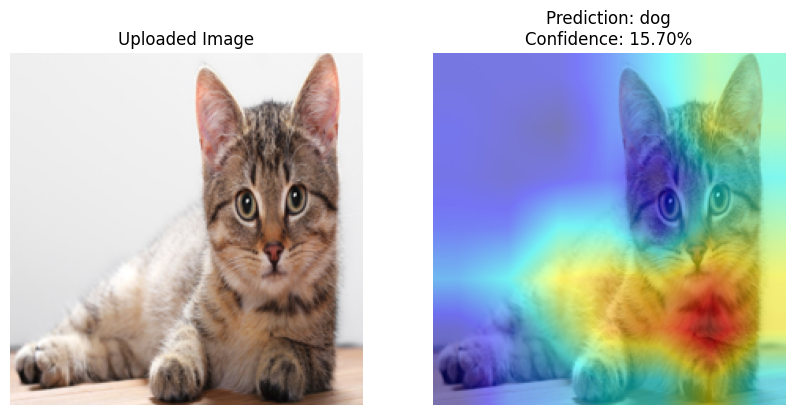

In [52]:
# @title 🚀 Step 4: Run Predictions
# Change these filenames to exactly match what you uploaded (e.g., 'plane.jpg')
print("Testing the Plane image...")
predict_custom_image('plane.jpg') # <-- Update the extension if needed (.jpg, .png, etc.)

print("\nTesting the Cat image...")
predict_custom_image('cat.jpg')   # <-- Update the extension if needed